<a href="https://colab.research.google.com/github/tmiqueluzzi/florianopolis_x_mapbiomas/blob/main/InformacoesRaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readme

- Cópia de um arquivo do Jupyter onde, na pasta, estão todos os arquivos utilizados no código
- A ideia é vetorizar um lote de rasters e cortá-los usando uma camada de máscara

# Código

## Obtendo camada de máscara

In [ ]:
import geopandas as gpd

camadas = gpd.list_layers("ShapesProjetoFpolisMapBiomas.gpkg")
print(camadas)

In [ ]:
area_corte_raster = gpd.read_file(
    "ShapesProjetoFpolisMapBiomas.gpkg",
    layer="geometrias_corrigidas"
)

area_corte_raster.head()

## Vetorizando o raster

In [ ]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

In [ ]:
raster_path = "florianopolis_1985_v1.tif"

with rasterio.open(raster_path) as src:
    raster = src.read(1)  # primeira banda
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

# Gerar geometrias vetoriais
geoms = (
    {
        "geometry": shape(geom),
        "value": value
    }
    for geom, value in shapes(
        raster,
        mask=raster != nodata,
        transform=transform
    )
)

# Converter para GeoDataFrame
gdf_vetor = gpd.GeoDataFrame(
    pd.DataFrame(geoms),
    crs=crs
)

gdf_vetor.head()

In [ ]:
# Garantir que ambas estão no mesmo CRS
if gdf_vetor.crs != area_corte_raster.crs:
    print('Diferentes')
    area_corte_raster = area_corte_raster.to_crs(gdf_vetor.crs)

## Recorte

In [ ]:
gdf_vetor_recortado = gpd.clip(
    gdf_vetor,
    area_corte_raster
)

#arruma geometria
gdf_vetor_recortado["geometry"] = (
    gdf_vetor_recortado.geometry
    .buffer(0)
)

gdf_vetor_recortado.head()

## Verificação

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

gdf_vetor.plot(
    ax=axs[0],
    column="value",
    legend=True
)
axs[0].set_title("Antes do recorte")

area_corte_raster.boundary.plot(
    ax=axs[0],
    color="red",
    linewidth=1
)

gdf_vetor_recortado.plot(
    ax=axs[1],
    column="value",
    legend=True
)
axs[1].set_title("Após o recorte")

plt.tight_layout()

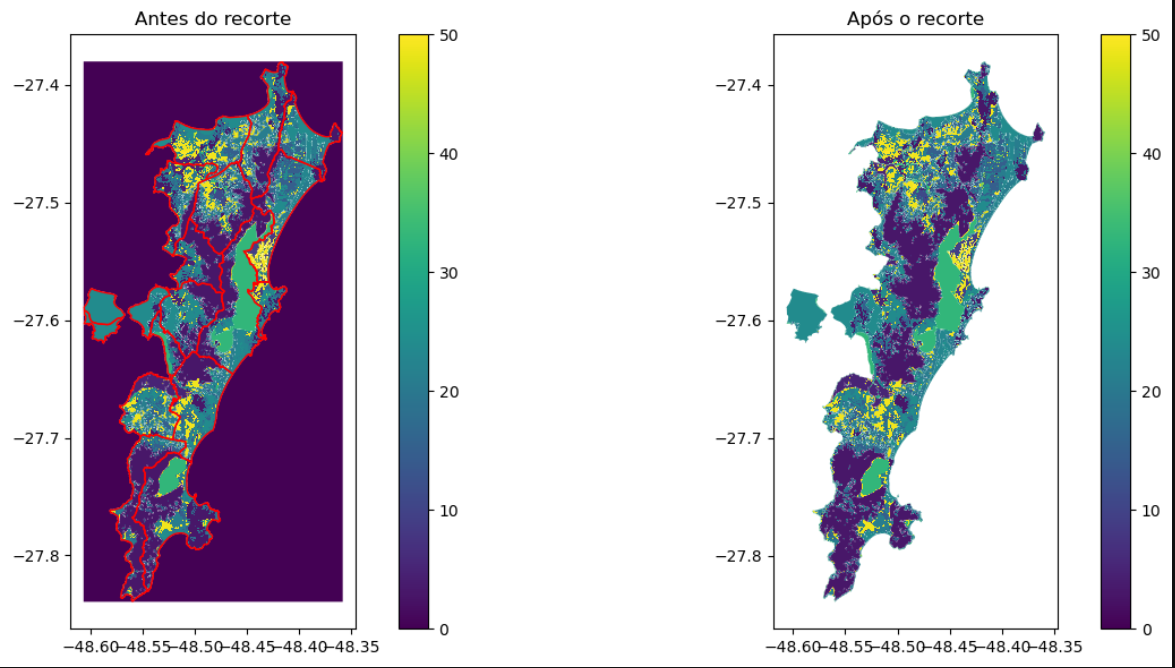

## Cria tabela (1 ano apenas)

In [ ]:
# tabela uso da

import geopandas as gpd

# --------------------------------------------------
# 1. Garantir mesmo CRS
# --------------------------------------------------
if area_corte_raster.crs != gdf_vetor_recortado.crs:
    gdf_vetor_recortado = gdf_vetor_recortado.to_crs(area_corte_raster.crs)

# --------------------------------------------------
# 2. Garantir geometrias válidas
# --------------------------------------------------
area_corte_raster["geometry"] = area_corte_raster.geometry.buffer(0)
gdf_vetor_recortado["geometry"] = gdf_vetor_recortado.geometry.buffer(0)

# --------------------------------------------------
# 3. Interseção espacial (overlay)
# --------------------------------------------------
gdf_intersec = gpd.overlay(
    area_corte_raster,
    gdf_vetor_recortado,
    how="intersection"
)

# --------------------------------------------------
# 4. Cálculo de área (CRS projetado!)
# --------------------------------------------------
gdf_intersec["area_m2"] = gdf_intersec.area
gdf_intersec["area_ha"] = gdf_intersec["area_m2"] / 10_000

# --------------------------------------------------
# 5. Agregação por distrito e uso do solo
# --------------------------------------------------
# Ajuste os nomes das colunas abaixo, se necessário
tabela_area = (
    gdf_intersec
    .groupby(["nome", "value"], as_index=False)
    .agg({"area_ha": "sum"})
)

tabela_area